In [76]:
#!pip install seaborn pytorch lightning pandas numpy scikit-learn

# Anomaly Detection in CANBus Traffic with LSTM and Autoencoders

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

## Data loading and preprocessing

In [3]:
import lightning.pytorch as pl
from torch.utils.data import random_split, DataLoader
from sklearn import preprocessing

class CANDataModule(pl.LightningDataModule):
    def __init__(self, data_file: str = "data/can_generated/10_second_master_and_slave.csv", batch_size = 10, debug=False):
        super().__init__()
        self.data_file = data_file
        self.batch_size = batch_size
        self.debug = debug


    def prepare_data(self):
        df = pd.read_csv(self.data_file)
        preprocessed_data = df[
            [
                'priority','function','subfunction','node_id', # CANID
                'len', # Length del payload
                'd0','d1','d2','d3','d4','d5','d6','d7' # Payload
            ]
        ]
        preprocessed_data = preprocessed_data.apply(lambda x: x.astype(str).map(lambda x: float(int(x, base=16))))

        # Feature Scaling
        # Acá hay un púnto importante, no se debe usar MinMax porque los campos de los CANID son valores enumerados.
        # Debería pasar por otra etapa de transformación antes.
        x = preprocessed_data.values
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        preprocessed_data = pd.DataFrame(x_scaled)

        self.preprocessed_data = preprocessed_data
        self.data = preprocessed_data.values
        self.data = np.expand_dims(self.data,1).astype('float32')

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        self.can_train, self.can_val = random_split(self.data, [self.data.shape[0]-40, 40])

        # Assign test dataset for use in dataloader(s). The source repo did not have test or prediction data so just reuse the entire dataset
        self.can_test = self.data
        self.can_predict = self.data

    def train_dataloader(self):
        return DataLoader(self.can_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.can_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.can_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.can_predict, batch_size=self.batch_size)

In [8]:
import torch
from torch import optim, nn, utils, Tensor
import lightning.pytorch as pl

# define the LightningModule
class AutoEncoder(pl.LightningModule):
    def __init__(self, t_dim, feat_dim):
        super().__init__()
        self.L1 = nn.LSTM(feat_dim, 16, batch_first=True)
        self.L2 = nn.LSTM(16, 4, batch_first=True)
        self.L4 = nn.LSTM(4, 4, batch_first=True)
        self.L5 = nn.LSTM(4, 16, batch_first=True)
        self.output = nn.Linear(16, feat_dim)

    def forward(self, batch):
        x = batch
        z, _ = self.L1(x)
        z, _ =  self.L2(nn.functional.relu(z))
        x_hat, _ = self.L4(nn.functional.relu(z))
        x_hat, _ = self.L5(nn.functional.relu(x_hat))
        x_hat = self.output(nn.functional.relu(x_hat))
        return x_hat

    def _common_step(self, batch, batch_index):
        x_hat = self.forward(batch)
        loss = nn.functional.l1_loss(x_hat, batch)
        # Logging to TensorBoard (if installed) by default
        return loss

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        loss = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        loss =  self._common_step(batch, batch_idx)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
t_dim = 1
feat_dim = 13
autoencoder = AutoEncoder(t_dim,feat_dim)


## Training

Required format for LSTM input is (N_SAMPLES,N_TIMESTEPS,N_FEATURES)
- TODO: HP tuning de N_TIMESTEPS

In [9]:
data_module = CANDataModule()
trainer = pl.Trainer(max_epochs=100)
trainer.fit(autoencoder, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | L1     | LSTM   | 2.0 K 
1 | L2     | LSTM   | 352   
2 | L4     | LSTM   | 160   
3 | L5     | LSTM   | 1.4 K 
4 | output | Linear | 221   
----------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/manny/development/anaconda3/envs/can-anomaly-detection/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/manny/development/anaconda3/envs/can-anomaly-detection/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/manny/development/anaconda3/envs/can-anomaly-detection/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [10]:
X_pred = autoencoder(torch.from_numpy(data_module.data)).squeeze().detach().numpy()
X_pred = pd.DataFrame(X_pred, columns=data_module.preprocessed_data.columns)
X_pred.shape


(402, 13)

In [11]:
Xtrain = data_module.data.squeeze()
Xtrain.shape

(402, 13)

/tmp/ipykernel_1615750/3771452476.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


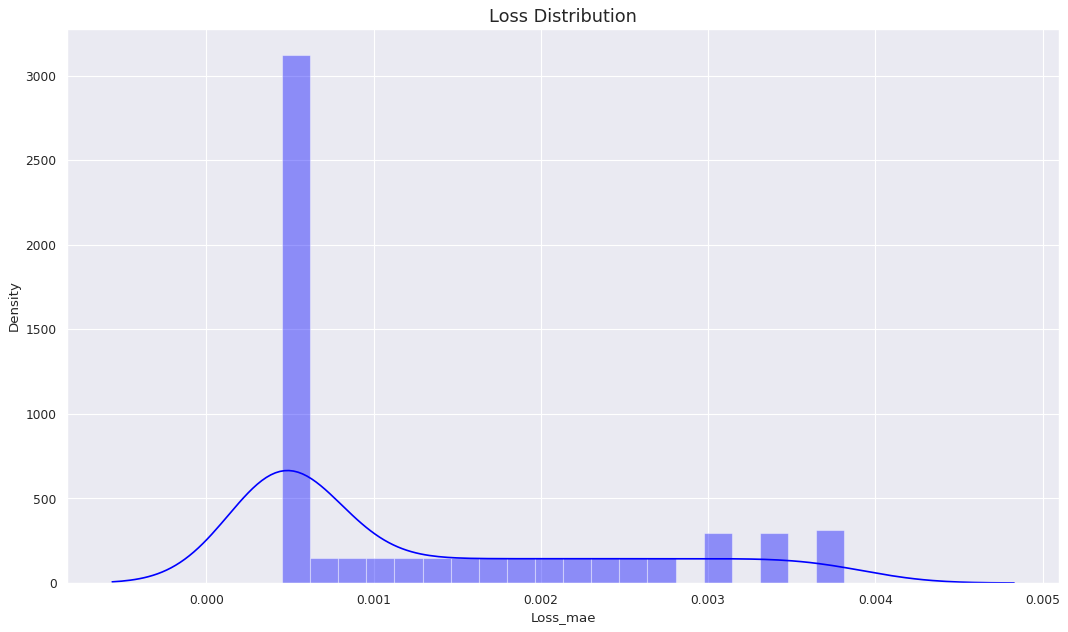

In [13]:
# plot the loss distribution of the training set
X_pred = pd.DataFrame(X_pred, columns=data_module.preprocessed_data.columns)
X_pred.index = data_module.preprocessed_data.index

scored = pd.DataFrame(index=data_module.preprocessed_data.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');

<Axes: >

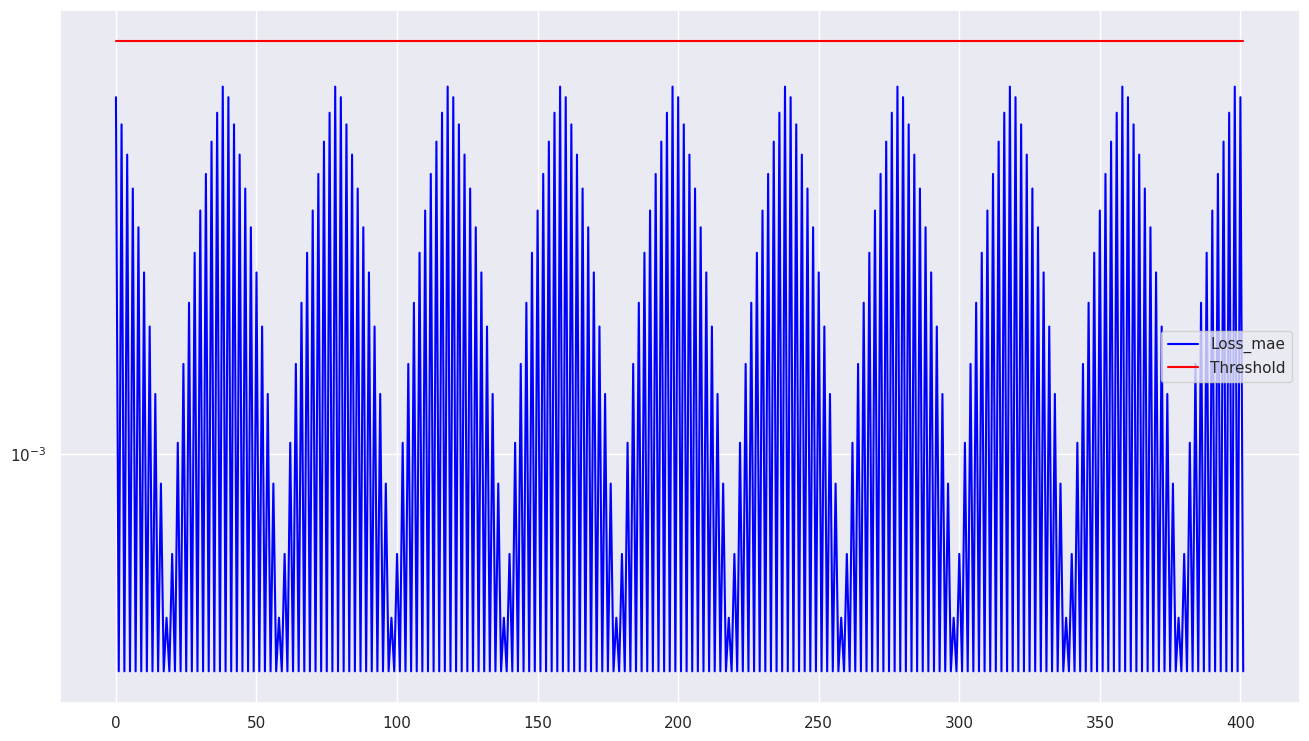

In [14]:
scored['Threshold'] = 0.0045
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])

In [15]:
def process_file(csv_file):
    test = pd.read_csv(csv_file)

    # Selección de columnas de interés
    test = test[
        [
            'priority','function','subfunction','node_id', # CANID
            'len', # Length del payload
            'd0','d1','d2','d3','d4','d5','d6','d7' # Payload
        ]
    ]
    test = test.apply(lambda x: x.astype(str).map(lambda x: float(int(x, base=16))))
    x = test.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    test = pd.DataFrame(x_scaled)

    X_test = test.values
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # calculate the loss on the test set
    X_pred = autoencoder(torch.from_numpy(X_test).float()).detach().numpy()
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test.columns)
    X_pred.index = test.index

    scored = pd.DataFrame(index=test.index)
    Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
    scored['Threshold'] = 0.0045
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    #scored.head()

    # plot bearing failure time plot
    scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])

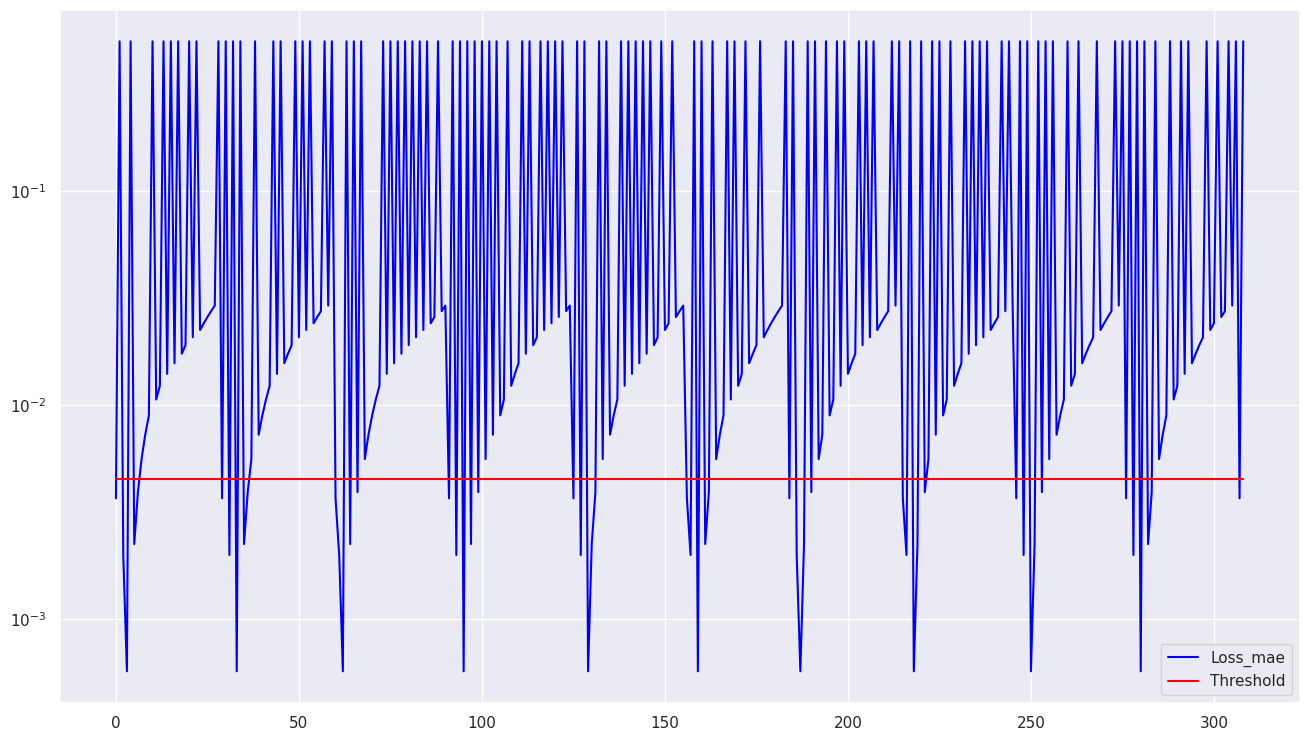

In [17]:
process_file("data/can_generated/10_second_master_and_slave_broken.csv")